## Algorithm 2 (peer-reviewed):
https://drpress.org/ojs/index.php/HSET/article/view/23096/22654

Train shape: (1000, 36), Test shape: (460, 36)

=== Linear Regression (Test set) ===
Raw target (price units):
  MSE:   1,217,049,842.74
  MAE:   23,088.77
  RMSE:  34,886.24
  R^2:   0.8221
Scaled target (standardized SalePrice):
  MSE_z:  0.2008
  MAE_z:  0.2966
  RMSE_z: 0.4481

=== Random Forest (Test set) ===
Raw target (price units):
  MSE:   723,926,593.06
  MAE:   17,262.19
  RMSE:  26,905.88
  R^2:   0.8942
Scaled target (standardized SalePrice):
  MSE_z:  0.1194
  MAE_z:  0.2217
  RMSE_z: 0.3456

=== Linear Regression Coefficients (on scaled X, raw y) ===
Intercept: 181,010.9720
MSSubClass: -9,883.2550
LotFrontage: -2,821.9509
LotArea: 4,974.9281
OverallQual: 25,593.0906
OverallCond: 3,391.7921
YearBuilt: 7,304.0404
YearRemodAdd: 3,543.2308
MasVnrArea: 3,711.3487
BsmtFinSF1: 3,278.1078
BsmtFinSF2: -587.7940
BsmtUnfSF: -1,365.3587
TotalBsmtSF: 1,817.9110
1stFlrSF: 7,397.6195
2ndFlrSF: 8,413.5526
LowQualFinSF: 1,352.5980
GrLivArea: 12,552.7680
BsmtFullBath: 6,499.4055
BsmtHalfB

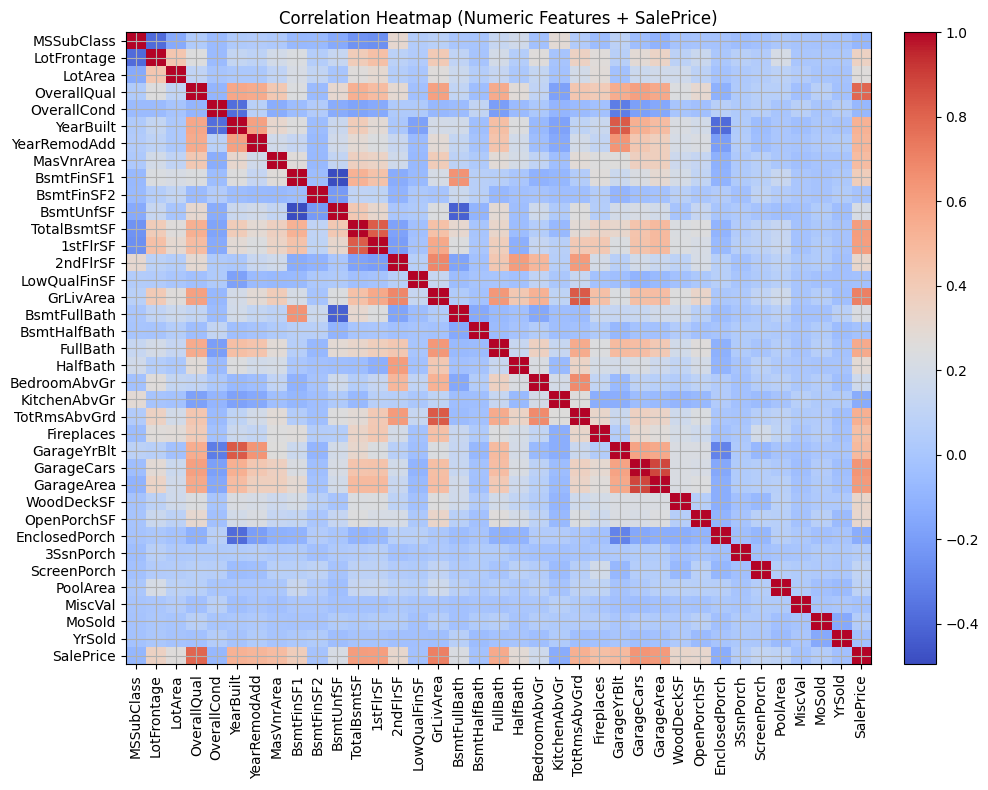

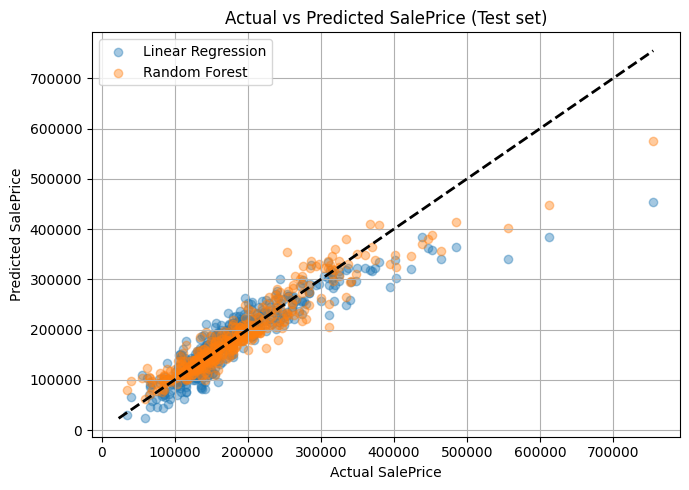

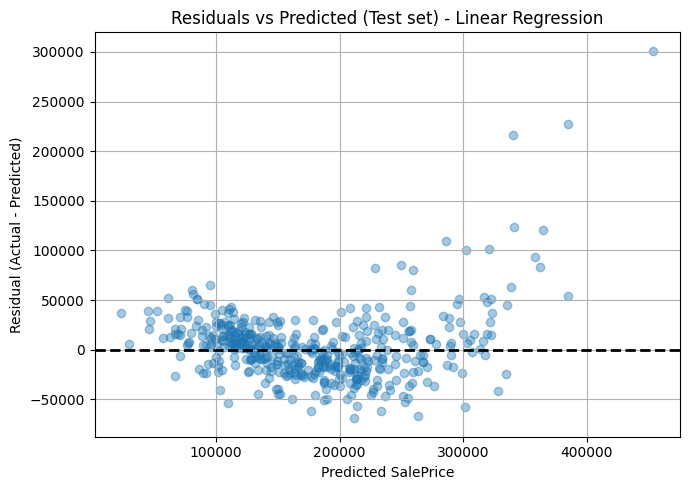

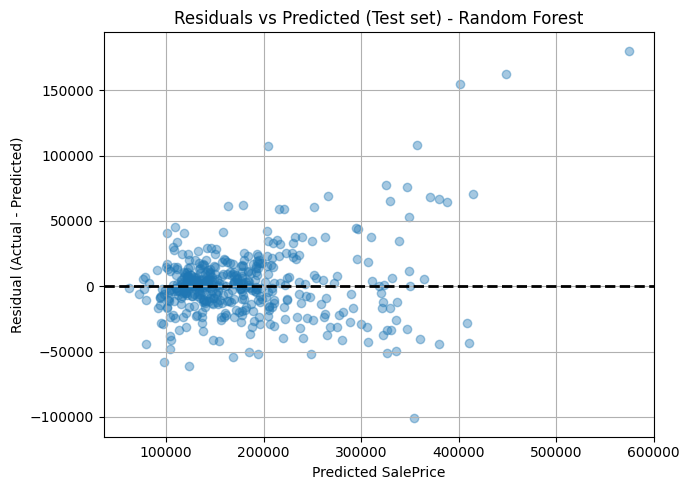

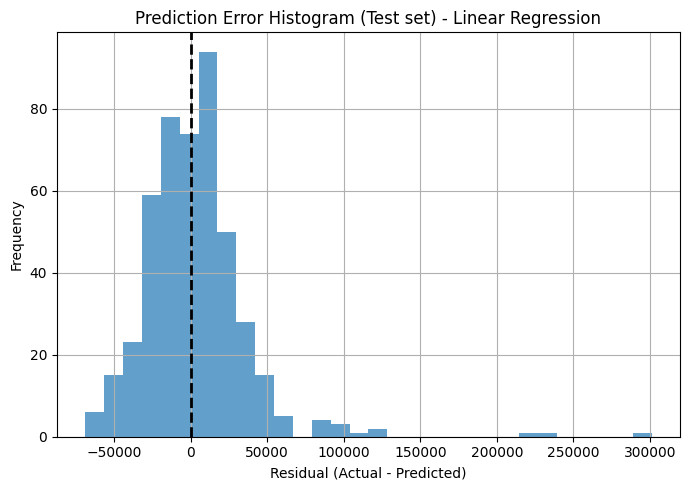

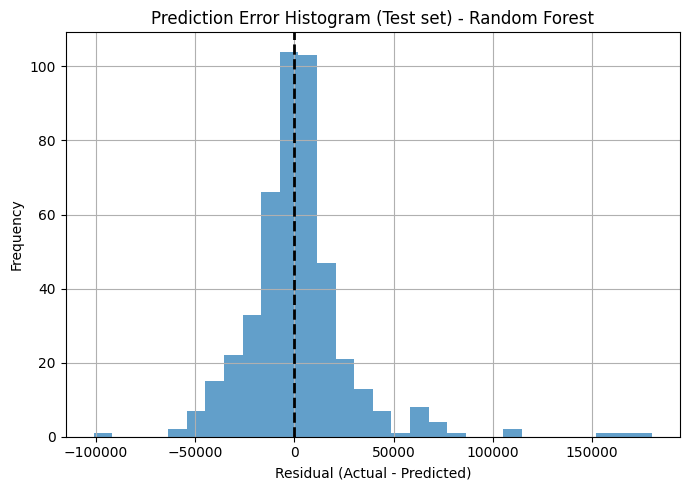

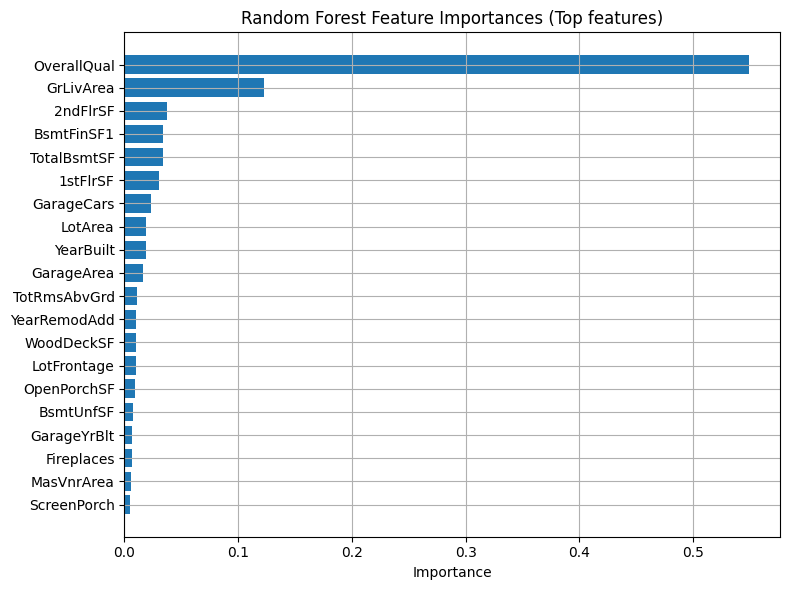

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

CSV_PATH = "train.csv"
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
def preprocess_paper_style_scaled(csv_path=CSV_PATH, random_state=42):
    df = pd.read_csv(csv_path)
    df = df.drop(columns=["Id"], errors="ignore")

    target_col = "SalePrice"
    if target_col not in df.columns:
        raise ValueError("SalePrice column not found in the dataset.")

    df_num = df.select_dtypes(include=["number"]).copy()

    if target_col not in df_num.columns:
        raise ValueError("SalePrice is not in the numeric subset.")

    corr_matrix = df_num.corr()
    y_raw = df_num[target_col].copy()
    X_raw = df_num.drop(columns=[target_col])
    feature_names = X_raw.columns.tolist()
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X_raw),
        columns=feature_names
    )

    #1000 / 460 split
    test_size = 460 / len(df_num)
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
        X_imputed,
        y_raw,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
    )
    X_scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        X_scaler.fit_transform(X_train_raw),
        columns=feature_names
    )
    X_test_scaled = pd.DataFrame(
        X_scaler.transform(X_test_raw),
        columns=feature_names
    )

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1)).ravel()

    print(f"Train shape: {X_train_raw.shape}, Test shape: {X_test_raw.shape}")

    return {
        "X_train_raw": X_train_raw,
        "X_test_raw": X_test_raw,
        "y_train_raw": y_train_raw,
        "y_test_raw": y_test_raw,
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "corr_matrix": corr_matrix,
        "feature_names": feature_names,
        "X_scaler": X_scaler,
        "y_scaler": y_scaler,
    }


def train_models(X_train_scaled, y_train_raw):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train_raw)

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train_raw)

    return lin_reg, rf

def evaluate_model(name, y_true_raw, y_pred_raw, y_scaler):
    mse_raw = mean_squared_error(y_true_raw, y_pred_raw)
    mae_raw = mean_absolute_error(y_true_raw, y_pred_raw)
    rmse_raw = np.sqrt(mse_raw)
    r2_raw = r2_score(y_true_raw, y_pred_raw)
    y_true_scaled = y_scaler.transform(y_true_raw.values.reshape(-1, 1)).ravel()
    y_pred_scaled = y_scaler.transform(y_pred_raw.reshape(-1, 1)).ravel()

    mse_scaled = mean_squared_error(y_true_scaled, y_pred_scaled)
    mae_scaled = mean_absolute_error(y_true_scaled, y_pred_scaled)
    rmse_scaled = np.sqrt(mse_scaled)

    print(f"\n=== {name} (Test set) ===")
    print("Raw target (price units):")
    print(f"  MSE:   {mse_raw:,.2f}")
    print(f"  MAE:   {mae_raw:,.2f}")
    print(f"  RMSE:  {rmse_raw:,.2f}")
    print(f"  R^2:   {r2_raw:.4f}")
    print("Scaled target (standardized SalePrice):")
    print(f"  MSE_z:  {mse_scaled:.4f}")
    print(f"  MAE_z:  {mae_scaled:.4f}")
    print(f"  RMSE_z: {rmse_scaled:.4f}")

    return {
        "raw": {
            "mse": mse_raw,
            "mae": mae_raw,
            "rmse": rmse_raw,
            "r2": r2_raw,
        },
        "scaled": {
            "mse": mse_scaled,
            "mae": mae_scaled,
            "rmse": rmse_scaled,
        },
    }

def plot_correlation_heatmap(corr_matrix):
    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr_matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title("Correlation Heatmap (Numeric Features + SalePrice)")
    plt.tight_layout()


def plot_actual_vs_predicted(y_test_raw, y_pred_lr, y_pred_rf):
    y_true = np.array(y_test_raw)

    plt.figure()
    plt.scatter(y_true, y_pred_lr, alpha=0.4, label="Linear Regression")
    plt.scatter(y_true, y_pred_rf, alpha=0.4, label="Random Forest")

    min_val = min(y_true.min(), y_pred_lr.min(), y_pred_rf.min())
    max_val = max(y_true.max(), y_pred_lr.max(), y_pred_rf.max())
    plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=2)

    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title("Actual vs Predicted SalePrice (Test set)")
    plt.legend()
    plt.tight_layout()


def plot_residuals_scatter(y_test_raw, preds_dict):
    y_true = np.array(y_test_raw)

    for name, y_pred in preds_dict.items():
        residuals = y_true - y_pred

        plt.figure()
        plt.scatter(y_pred, residuals, alpha=0.4)
        plt.axhline(0, color="k", linestyle="--", linewidth=2)
        plt.xlabel("Predicted SalePrice")
        plt.ylabel("Residual (Actual - Predicted)")
        plt.title(f"Residuals vs Predicted (Test set) - {name}")
        plt.tight_layout()


def plot_prediction_error_histograms(y_test_raw, preds_dict, bins: int = 30):
    y_true = np.array(y_test_raw)

    for name, y_pred in preds_dict.items():
        residuals = y_true - y_pred

        plt.figure()
        plt.hist(residuals, bins=bins, alpha=0.7)
        plt.axvline(0, color="k", linestyle="--", linewidth=2)
        plt.xlabel("Residual (Actual - Predicted)")
        plt.ylabel("Frequency")
        plt.title(f"Prediction Error Histogram (Test set) - {name}")
        plt.tight_layout()


def plot_feature_importances(rf_model, feature_names, top_n=20):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    if top_n is not None:
        indices = indices[:top_n]

    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(8, 6))
    y_pos = np.arange(len(sorted_features))
    plt.barh(y_pos, sorted_importances[::-1])
    plt.yticks(y_pos, sorted_features[::-1])
    plt.xlabel("Importance")
    plt.title("Random Forest Feature Importances (Top features)")
    plt.tight_layout()


def print_linear_regression_coeffs(lin_reg, feature_names):
    print("\n=== Linear Regression Coefficients (on scaled X, raw y) ===")
    print(f"Intercept: {lin_reg.intercept_:,.4f}")
    for name, coef in zip(feature_names, lin_reg.coef_):
        print(f"{name}: {coef:,.4f}")

if __name__ == "__main__":
    data = preprocess_paper_style_scaled(CSV_PATH, random_state=42)

    X_train_scaled = data["X_train_scaled"]
    X_test_scaled = data["X_test_scaled"]
    y_train_raw = data["y_train_raw"]
    y_test_raw = data["y_test_raw"]
    corr_matrix = data["corr_matrix"]
    feature_names = data["feature_names"]
    y_scaler = data["y_scaler"]
    plot_correlation_heatmap(corr_matrix)
    lin_reg, rf = train_models(X_train_scaled, y_train_raw)
    y_pred_lr_test = lin_reg.predict(X_test_scaled)
    y_pred_rf_test = rf.predict(X_test_scaled)
    eval_lr = evaluate_model("Linear Regression", y_test_raw, y_pred_lr_test, y_scaler)
    eval_rf = evaluate_model("Random Forest", y_test_raw, y_pred_rf_test, y_scaler)
    print_linear_regression_coeffs(lin_reg, feature_names)
    preds_dict = {
        "Linear Regression": y_pred_lr_test,
        "Random Forest": y_pred_rf_test,
    }

    plot_actual_vs_predicted(y_test_raw, y_pred_lr_test, y_pred_rf_test)
    plot_residuals_scatter(y_test_raw, preds_dict)
    plot_prediction_error_histograms(y_test_raw, preds_dict, bins=30)
    plot_feature_importances(rf, feature_names, top_n=20)

    plt.show()
